# Offline Mining of Evaluation Sets

## Training Evaluation

In [78]:
import os
import xmltodict
import pickle
import random
from collections import Counter

from imageio import imread

DATA_PATH_STR = 'data/ILSVRC2015-VID-Curation/Data/VID/'
TRAIN_STATS_PKL = 'dataset/imagenetvid/train_data_stats.pkl'
VAL_STATS_PKL = 'dataset/imagenetvid/val_data_stats.pkl'
SUBDIR_MAP = {'ILSVRC2015_VID_train_0000': 'a',
            'ILSVRC2015_VID_train_0001': 'b',
            'ILSVRC2015_VID_train_0002': 'c',
            'ILSVRC2015_VID_train_0003': 'd',
            '': 'e'}

TRAIN_EVAL_SET_PKL = 'dataset/imagenetvid/train_eval_set.pkl'
TRAIN_EVAL_STATS_PKL = 'dataset/imagenetvid/train_eval_stats.pkl'
VAL_EVAL_SET_PKL = 'dataset/imagenetvid/val_eval_set.pkl'
VAL_EVAL_STATS_PKL = 'dataset/imagenetvid/val_eval_stats.pkl'



def make_validation_pickle():
    val_eval_dataset, stats = [], Counter()
    output = open(VAL_EVAL_SET_PKL, 'wb')
    snippets = _get_snippets_dict(training=False)

    # For each random multiobject video snippets
    for video_snippet, _ in snippets['multiple_bboxes']:
        # Choose a random frame
        frame_annotation1 = _get_random_frame_annotation(video_snippet)

        # Choose a random, non-occluded object in the image and call it anchor
        anchor = _get_random_object_annotation(frame_annotation1, allow_occluded=False)
        if anchor == None: continue
        trackid = anchor['trackid']
        # (Put the object class in a dictionary for stats)
        stats[anchor['name']] += 1

        found_positive = False
        timeout = 100
        while not found_positive and timeout > 0:
            timeout -= 1
            # Find a second frame
            frame_annotation2 = _get_random_frame_annotation(video_snippet)
            while frame_annotation1['filename'] == frame_annotation2['filename']:
                frame_annotation2 = _get_random_frame_annotation(video_snippet)

            # Find the same object in this frame and verify it's not occluded
            positive = _get_object(frame_annotation2, trackid)
            if positive == None: continue
            # (if it is, repeat the last step until we find a good frame)
            if positive['occluded'] == '0':
                found_positive = True
        if timeout == 0 or found_positive == False: continue

        # Store all the objects of the last frame in a list
        all_objects = _get_all_objects(frame_annotation2)
        if len(all_objects) < 3: continue
        # (Put the object class in a dictionary for stats)
        for o in all_objects: stats[o['name']] += 1

        # Label the first object and the same one from the list
        # as 0, and the rest as 1
        zero_if_equal_one_otherwise = lambda o: 0 if o['trackid'] == trackid else 1
        labels = [0] + [zero_if_equal_one_otherwise(o) for o in all_objects]

        # Prepare batch
        images = [_get_framepath(frame_annotation1, trackid, training=False)] + \
          [_get_framepath(frame_annotation2, o['trackid'], training=False) for o in all_objects]
        batch = (images, labels)

        # Put this batch into the pickle
        pickle.dump(batch, output, -1)

    # Store the metadata into another pickle
    output.close()
    output = open(VAL_EVAL_STATS_PKL, 'wb')
    pickle.dump(stats, output, -1)
    output.close()


def make_training_eval_pickle():
    training_eval_dataset, stats = [], Counter()
    output = open(TRAIN_EVAL_SET_PKL, 'wb')
    snippets = _get_snippets_dict(training=True)

    # For each random multiobject video snippets
    for video_snippet, _ in snippets['multiple_bboxes']:
        # Choose a random frame
        frame_annotation1 = _get_random_frame_annotation(video_snippet)

        # Choose a random, non-occluded object in the image and call it anchor
        anchor = _get_random_object_annotation(frame_annotation1, allow_occluded=False)
        if anchor == None: continue
        trackid = anchor['trackid']
        # (Put the object class in a dictionary for stats)
        stats[anchor['name']] += 1

        found_positive = False
        timeout = 100
        while not found_positive and timeout > 0:
            timeout -= 1
            # Find a second frame
            frame_annotation2 = _get_random_frame_annotation(video_snippet)
            while frame_annotation1['filename'] == frame_annotation2['filename']:
                frame_annotation2 = _get_random_frame_annotation(video_snippet)

            # Find the same object in this frame and verify it's not occluded
            positive = _get_object(frame_annotation2, trackid)
            if positive == None: continue
            # (if it is, repeat the last step until we find a good frame)
            if positive['occluded'] == '0':
                found_positive = True
        if timeout == 0 or found_positive == False: continue

        # Store all the objects of the last frame in a list
        all_objects = _get_all_objects(frame_annotation2)
        if len(all_objects) < 3: continue
        # (Put the object class in a dictionary for stats)
        for o in all_objects: stats[o['name']] += 1

        # Label the first object and the same one from the list
        # as 0, and the rest as 1
        zero_if_equal_one_otherwise = lambda o: 0 if o['trackid'] == trackid else 1
        labels = [0] + [zero_if_equal_one_otherwise(o) for o in all_objects]

        # Prepare batch
        images = [_get_framepath(frame_annotation1, trackid, training=True)] + \
          [_get_framepath(frame_annotation2, o['trackid'], training=True) for o in all_objects]
        batch = (images, labels)

        # Put this batch into the pickle
        pickle.dump(batch, output, -1)

    # Store the metadata into another pickle
    output.close()
    output2 = open(TRAIN_EVAL_STATS_PKL, 'wb')
    pickle.dump(stats, output2, -1)
    output2.close()


def _get_snippets_dict(training=True):
    """
    Returns a structure that contains the video snippets categorized by
    'missing_bbox', 'single_bboxes', 'multiple_bboxes', and 'all'.
    """
    if training:
        pkl_file = open(TRAIN_STATS_PKL, 'rb')
        print("Loading training pickle...")
    else:
        pkl_file = open(VAL_STATS_PKL, 'rb')
        print("Loading validation pickle...")

    stats = pickle.load(pkl_file)
    paths = pickle.load(pkl_file)
    pkl_file.close()

    return paths


def _get_random_frame_annotation(snippet_path):
    frame_files = os.listdir(snippet_path)
    random.shuffle(frame_files)
    for file in frame_files:
        if file[-3:] != 'xml': continue
        annotation_path = os.path.join(snippet_path, file)
        return _get_annotation(annotation_path)


def _get_pair_of_frames(snippet_path):
    frames = [_get_random_frame_annotation(snippet_path) for _ in range(2)]
    order_by_time = lambda f: int(f['filename'])
    return tuple(sorted(frames, key=order_by_time))


def _get_random_object_annotation(annotation, allow_occluded=True):
    if 'object' in annotation:
        obj = annotation['object']
        if type(obj) == list and len(obj) > 0:
            # multiple objects
            random.shuffle(obj)
            for o in obj:
                if allow_occluded or o['occluded'] == '0':
                    return o
        else:
            # single object
            if allow_occluded or obj['occluded'] == '0':
                return obj


def _get_all_objects(annotation):
    all_objects = []
    if 'object' in annotation:
        obj = annotation['object']
        if type(obj) == list and len(obj) > 0:
            # multiple objects
            all_objects = obj
        else:
            # single object
            all_objects.append(obj)
    return all_objects


def _get_annotation(annotation_path):
    with open(annotation_path) as file:
        xmlobj = xmltodict.parse(file.read())
    annotation = xmlobj['annotation']
    return annotation


def _get_object(annotation, trackid):
    if 'object' in annotation:
        obj = annotation['object']
        if type(obj) == list and len(obj) > 0:
            # multiple objects
            for o in obj:
                if o['trackid'] == trackid:
                    return o
        else:
            # single object
            if obj['trackid'] == trackid:
                return obj


def _get_framepath(annotation, track_id, training=True):
    """Assumes track_id is a string and not an int."""
    def _get_full_snippetpath(snippet_path):
        return os.path.join(DATA_PATH_STR, 'train', snippet_path)
    
    if training:
        folder1, folder2 = annotation["folder"].split('/')
        snippet_path = os.path.join(SUBDIR_MAP[folder1], folder2)
    else:
        snippet_path = 'e/' + annotation["folder"]
    full_snippet_path = _get_full_snippetpath(snippet_path)

    if len(track_id) == 1:
        track_id = "0" + track_id

    filename = annotation["filename"]
    real_filename = filename + "." + track_id + ".crop.x.jpg"

    return os.path.join(full_snippet_path, real_filename)

In [79]:
make_training_eval_pickle()

Loading training pickle...


In [80]:
def print_top(path):
    pkl_file = open(path, 'rb')
    print(pickle.load(pkl_file))
    pkl_file.close()

print_top(TRAIN_EVAL_SET_PKL)

(['data/ILSVRC2015-VID-Curation/Data/VID/train/b/ILSVRC2015_train_00284016/000265.02.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/b/ILSVRC2015_train_00284016/000164.00.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/b/ILSVRC2015_train_00284016/000164.01.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/b/ILSVRC2015_train_00284016/000164.02.crop.x.jpg'], [0, 1, 1, 0])


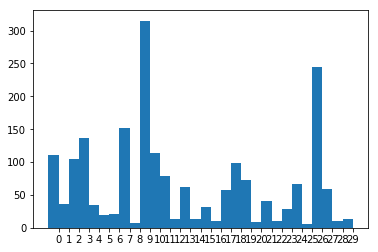

In [81]:
import numpy as np
import matplotlib.pyplot as plt

pkl_file = open(TRAIN_EVAL_STATS_PKL, 'rb')
stats = pickle.load(pkl_file)
pkl_file.close()

counts = {}
i = 0
for k, v in stats.items():
    counts[i] = v
    i += 1
    
assert len(counts) == 30, 'missing some class!'

labels, values = zip(*counts.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

## Validation

In [88]:
make_validation_pickle()

Loading validation pickle...


In [89]:
pkl_file = open(VAL_EVAL_SET_PKL, 'rb')
print(pickle.load(pkl_file))
pkl_file.close()

(['data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000002.06.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.00.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.01.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.02.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.03.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.04.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.05.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.06.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.07.crop.x.jpg', 'data/ILSVRC2015-VID-Curation/Data/VID/train/e/ILSVRC2015_val_00007024/000012.08.crop.x.jpg'], [0, 1, 1, 1, 1, 1, 1, 0, 1, 1])


missing some class!


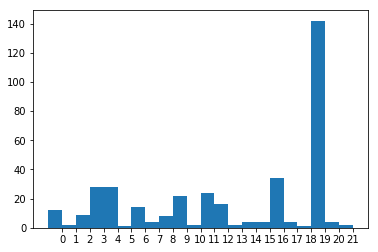

In [90]:
import numpy as np
import matplotlib.pyplot as plt

pkl_file = open(VAL_EVAL_STATS_PKL, 'rb')
stats = pickle.load(pkl_file)
pkl_file.close()

counts = {}
i = 0
for k, v in stats.items():
    counts[i] = v
    i += 1
    
if len(counts) < 30:
    print('missing some class!')

labels, values = zip(*counts.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()